# Cross-lingual Books Alignment with Transformers and OpenVINO™

Cross-lingual text alignment is the task of matching sentences in a pair of texts that are translations of each other. In this notebook, you'll learn how to use a deep learning model to create a parallel book in English and German

This method helps you learn languages but also provides parallel texts that can be used to train machine translation models. This is particularly useful if one of the languages is low-resource or you don't have enough data to train a full-fledged translation model.

The notebook shows how to accelerate the most computationally expensive part of the pipeline - getting vectors from sentences - using the OpenVINO™ framework.


## Pipeline

The notebook guides you through the entire process of creating a parallel book: from obtaining raw texts to building a visualization of aligned sentences. Here is the pipeline diagram:

![](https://user-images.githubusercontent.com/51917466/254582697-18f3ab38-e264-4b2c-a088-8e54b855c1b2.png")

Visualizing the result allows you to identify areas for improvement in the pipeline steps, as indicated in the diagram.

## Prerequisites

- `requests` - for getting books
- `pysbd` - for splitting sentences
- `transformers[torch]` and `openvino_dev` - for getting sentence embeddings
- `seaborn` - for alignment matrix visualization
- `ipywidgets` - for displaying HTML and JS output in the notebook 
#### Table of content:- [Get Books](#Get-Books-Uparrow)
- [Clean Text](#Clean-Text-Uparrow)
- [Split Text](#Split-Text-Uparrow)
- [Get Sentence Embeddings](#Get-Sentence-Embeddings-Uparrow)
    - [Optimize the Model with OpenVINO](#Optimize-the-Model-with-OpenVINO-Uparrow)
- [Calculate Sentence Alignment](#Calculate-Sentence-Alignment-Uparrow)
- [Postprocess Sentence Alignment](#Postprocess-Sentence-Alignment-Uparrow)
- [Visualize Sentence Alignment](#Visualize-Sentence-Alignment-Uparrow)
- [Speed up Embeddings Computation](#Speed-up-Embeddings-Computation-Uparrow)


In [1]:
!pip install -q requests pysbd transformers[torch] "openvino==2023.1.0.dev20230811" seaborn ipywidgets


[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## Get Books [$\Uparrow$](#Table-of-content:)

The first step is to get the books that we will be working with. For this notebook, we will use English and German versions of Anna Karenina by Leo Tolstoy. The texts can be obtained from the [Project Gutenberg site](https://www.gutenberg.org/). Since copyright laws are complex and differ from country to country, check the book's legal availability in your country. Refer to the Project Gutenberg Permissions, Licensing and other Common Requests [page](https://www.gutenberg.org/policy/permission.html) for more information.

Find the books on Project Gutenberg [search page](https://www.gutenberg.org/ebooks/) and get the ID of each book. To get the texts, we will pass the IDs to the [Gutendex](http://gutendex.com/) API.

In [2]:
import requests


def get_book_by_id(book_id: int, gutendex_url: str = "https://gutendex.com/") -> str:
    book_metadata_url = gutendex_url + "/books/" + str(book_id)
    request = requests.get(book_metadata_url, timeout=30)
    request.raise_for_status()

    book_metadata = request.json()
    book_url = book_metadata["formats"]["text/plain"]
    return requests.get(book_url).text


en_book_id = 1399
de_book_id = 44956

anna_karenina_en = get_book_by_id(en_book_id)
anna_karenina_de = get_book_by_id(de_book_id)

Let's check that we got the right books by showing a part of the texts:

In [3]:
print(anna_karenina_en[:1500])

﻿The Project Gutenberg eBook of Anna Karenina
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Anna Karenina


Author: graf Leo Tolstoy

Translator: Constance Garnett

Release date: July 1, 1998 [eBook #1399]
                Most recently updated: April 9, 2023

Language: English



*** START OF THE PROJECT GUTENBERG EBOOK ANNA KARENINA ***
[Illustration]




 ANNA KARENINA 

 by Leo Tolstoy 

 Translated by Constance Garnett 

Contents


 PART ONE
 PART TWO
 PART THREE
 PART FOUR
 PART FIVE
 PART SIX
 PART SEVEN
 PART EIGHT




PART ONE

Chapter 1


Happy families are all alike; every 

which in a raw format looks like this:

In [4]:
anna_karenina_en[:1500]

'\ufeffThe Project Gutenberg eBook of Anna Karenina\r\n    \r\nThis ebook is for the use of anyone anywhere in the United States and\r\nmost other parts of the world at no cost and with almost no restrictions\r\nwhatsoever. You may copy it, give it away or re-use it under the terms\r\nof the Project Gutenberg License included with this ebook or online\r\nat www.gutenberg.org. If you are not located in the United States,\r\nyou will have to check the laws of the country where you are located\r\nbefore using this eBook.\r\n\r\nTitle: Anna Karenina\r\n\r\n\r\nAuthor: graf Leo Tolstoy\r\n\r\nTranslator: Constance Garnett\r\n\r\nRelease date: July 1, 1998 [eBook #1399]\r\n                Most recently updated: April 9, 2023\r\n\r\nLanguage: English\r\n\r\n\r\n\r\n*** START OF THE PROJECT GUTENBERG EBOOK ANNA KARENINA ***\r\n[Illustration]\r\n\r\n\r\n\r\n\r\n ANNA KARENINA \r\n\r\n by Leo Tolstoy \r\n\r\n Translated by Constance Garnett \r\n\r\nContents\r\n\r\n\r\n PART ONE\r\n PART TWO\r\n 

In [5]:
anna_karenina_de[:1500]

'\ufeffThe Project Gutenberg eBook of Anna Karenina, 1. Band\r\n    \r\nThis ebook is for the use of anyone anywhere in the United States and\r\nmost other parts of the world at no cost and with almost no restrictions\r\nwhatsoever. You may copy it, give it away or re-use it under the terms\r\nof the Project Gutenberg License included with this ebook or online\r\nat www.gutenberg.org. If you are not located in the United States,\r\nyou will have to check the laws of the country where you are located\r\nbefore using this eBook.\r\n\r\nTitle: Anna Karenina, 1. Band\r\n\r\n\r\nCreator: graf Leo Tolstoy\r\n\r\nRelease date: February 18, 2014 [eBook #44956]\r\n\r\nLanguage: German\r\n\r\n\r\n\r\n*** START OF THE PROJECT GUTENBERG EBOOK ANNA KARENINA, 1. BAND ***\r\n\r\n\r\n\r\nProduced by Norbert H. Langkau, Jens Nordmann and the\r\nOnline Distributed Proofreading Team at http://www.pgdp.net\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n                             Anna Karenina.\r\n\r\n\r\n      

## Clean Text [$\Uparrow$](#Table-of-content:)

The downloaded books may contain service information before and after the main text. The text might have different formatting styles and markup, for example, phrases from a different language enclosed in underscores for potential emphasis or italicization:


> Yes, <spell>Alabin</spell> was giving a dinner on glass tables, and the
tables sang, <spell>_Il mio tesoro_—not _Il mio tesoro_</spell> though, but something
better, and there were some sort of little decanters on the table, and
they were women, too,” he remembered.


The next stages of the pipeline will be difficult to complete without cleaning and normalizing the text. Since formatting may differ, manual work is required at this stage. For example, the main content in the German version is enclosed in `*       *       *       *       *`, so it is safe to remove everything before the first occurrence and after the last occurrence of these asterisks.

> **Hint**: There are text-cleaning libraries that clean up common flaws. If the source of the text is known, you can look for a library designed for that source, for example [`gutenberg_cleaner`](https://github.com/kiasar/gutenberg_cleaner). These libraries can reduce manual work and even automate the process.process.

In [6]:
import re
from contextlib import contextmanager
from tqdm.auto import tqdm


start_pattern_en = r"\nPART ONE"
anna_karenina_en = re.split(start_pattern_en, anna_karenina_en)[1].strip()

end_pattern_en = "*** END OF THE PROJECT GUTENBERG EBOOK ANNA KARENINA ***"
anna_karenina_en = anna_karenina_en.split(end_pattern_en)[0].strip()

In [7]:
start_pattern_de = "*       *       *       *       *"
anna_karenina_de = anna_karenina_de.split(start_pattern_de, maxsplit=1)[1].strip()
anna_karenina_de = anna_karenina_de.rsplit(start_pattern_de, maxsplit=1)[0].strip()

In [8]:
anna_karenina_en = anna_karenina_en.replace("\r\n", "\n")
anna_karenina_de = anna_karenina_de.replace("\r\n", "\n")

For this notebook, we will work only with the first chapter.

In [9]:
chapter_pattern_en = r"Chapter \d?\d"
chapter_1_en = re.split(chapter_pattern_en, anna_karenina_en)[1].strip()

In [10]:
chapter_pattern_de = r"\d?\d.\n\n"
chapter_1_de = re.split(chapter_pattern_de, anna_karenina_de)[1].strip()

Let's cut it out and define some cleaning functions.

In [11]:
def remove_single_newline(text: str) -> str:
    return re.sub(r"\n(?!\n)", " ", text)


def unify_quotes(text: str) -> str:
    return re.sub(r"['\"»«“”]", '"', text)


def remove_markup(text: str) -> str:
    text = text.replace(">=", "").replace("=<", "")
    return re.sub(r"_\w|\w_", "", text)

Combine the cleaning functions into a single pipeline. The `tqdm` library is used to track the execution progress. Define a context manager to optionally disable the progress indicators if they are not needed.

In [12]:
disable_tqdm = False


@contextmanager
def disable_tqdm_context():
    global disable_tqdm
    disable_tqdm = True
    yield
    disable_tqdm = False


def clean_text(text: str) -> str:
    text_cleaning_pipeline = [
        remove_single_newline,
        unify_quotes,
        remove_markup,
    ]    
    progress_bar = tqdm(text_cleaning_pipeline, disable=disable_tqdm)
    for clean_func in progress_bar:
        progress_bar.set_postfix_str(clean_func.__name__)
        text = clean_func(text)
    return text


chapter_1_en = clean_text(chapter_1_en)
chapter_1_de = clean_text(chapter_1_de)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## Split Text [$\Uparrow$](#Table-of-content:)

Dividing text into sentences is a challenging task in text processing. The problem is called [sentence boundary disambiguation](https://en.wikipedia.org/wiki/Sentence_boundary_disambiguation), which can be solved using heuristics or machine learning models. This notebook uses a `Segmenter` from the `pysbd` library, which is initialized with an [ISO language code](https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes), as the rules for splitting text into sentences may vary for different languages.

> **Hint**: The `book_metadata` obtained from the Gutendex contains the language code as well, enabling automation of this part of the pipeline.

In [13]:
import pysbd


splitter_en = pysbd.Segmenter(language="en", clean=True)
splitter_de = pysbd.Segmenter(language="de", clean=True)


sentences_en = splitter_en.segment(chapter_1_en)
sentences_de = splitter_de.segment(chapter_1_de)

len(sentences_en), len(sentences_de)

(32, 34)

## Get Sentence Embeddings [$\Uparrow$](#Table-of-content:)

The next step is to transform sentences into vector representations. Transformer encoder models, like BERT, provide high-quality embeddings but can be slow. Additionally, the model should support both chosen languages. Training separate models for each language pair can be expensive, so there are many models pre-trained on multiple languages simultaneously, for example:

- [multilingual-MiniLM](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2)
- [distiluse-base-multilingual-cased](https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v2)
- [bert-base-multilingual-uncased](https://huggingface.co/bert-base-multilingual-uncased)
- [LaBSE](https://huggingface.co/rasa/LaBSE)

LaBSE stands for [Language-agnostic BERT Sentence Embedding](https://arxiv.org/pdf/2007.01852.pdf) and supports 109+ languages. It has the same architecture as the BERT model but has been trained on a different task: to produce identical embeddings for translation pairs.

![](https://user-images.githubusercontent.com/51917466/254582913-51531880-373b-40cb-bbf6-1965859df2eb.png")

This makes LaBSE a great choice for our task and it can be reused for different language pairs still producing good results. 

In [14]:
from typing import List, Union, Dict
from transformers import AutoTokenizer, AutoModel, BertModel
import numpy as np
import torch
from openvino.runtime import CompiledModel as OVModel
import openvino as ov


model_id = "rasa/LaBSE"
pt_model = AutoModel.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

2023-09-15 12:39:59.574308: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-15 12:39:59.667563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 12:40:00.526309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The model has two outputs: `last_hidden_state` and `pooler_output`. For generating embeddings, you can use either the first vector from the `last_hidden_state`, which corresponds to the special `[CLS]` token, or the entire vector from the second input. Usually, the second option is used, but we will be using the first option as it also works well for our task. Fill free to experiment with different outputs to find the best fit.

In [15]:
def get_embeddings(
    sentences: List[str],
    embedding_model: Union[BertModel, OVModel],
) -> np.ndarray:
    if isinstance(embedding_model, OVModel):
        embeddings = [
            embedding_model(tokenizer(sent, return_tensors="np").data)[
                "last_hidden_state"
            ][0][0]
            for sent in tqdm(sentences, disable=disable_tqdm)
        ]
        return np.vstack(embeddings)
    else:
        embeddings = [
            embedding_model(**tokenizer(sent, return_tensors="pt"))[
                "last_hidden_state"
            ][0][0]
            for sent in tqdm(sentences, disable=disable_tqdm)
        ]
        return torch.vstack(embeddings)


embeddings_en_pt = get_embeddings(sentences_en, pt_model)
embeddings_de_pt = get_embeddings(sentences_de, pt_model)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

### Optimize the Model with OpenVINO [$\Uparrow$](#Table-of-content:)


The LaBSE model is quite large and can be slow to infer on some hardware, so let's optimize it with OpenVINO. [Model conversion Python API](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) accepts the PyTorch/Transformers model object and additional information about model inputs. An `example_input` is needed to trace the model execution graph, as PyTorch constructs it dynamically during inference. The converted model must be compiled for the target device using the `Core` object before it can be used.

In [16]:
# 3 inputs with dynamic axis [batch_size, sequence_length] and type int64
inputs_info = [([-1, -1], ov.Type.i64)] * 3
ov_model = ov.convert_model(
    pt_model,
    example_input=tokenizer("test", return_tensors="pt").data,
    input=inputs_info,
)

core = ov.Core()
compiled_model = core.compile_model(ov_model, "CPU")

embeddings_en = get_embeddings(sentences_en, compiled_model)
embeddings_de = get_embeddings(sentences_de, compiled_model)

[ WARNING ]  Please fix your imports. Module %s has been moved to %s. The old module will be deleted in version %s.


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- 

/home/ea/work/ov_venv/lib/python3.8/site-packages/torch/jit/annotations.py:309: UserWarning: TorchScript will treat type annotations of Tensor dtype-specific subtypes as if they are normal Tensors. dtype constraints are not enforced in compilation either.
  warnings.warn("TorchScript will treat type annotations of Tensor "


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

On an Intel Core i9-10980XE CPU, the PyTorch model processed 40-43 sentences per second. After optimization with OpenVINO, the processing speed increased to 56-60 sentences per second. This is about 40% performance boost with just a few lines of code. Let's check if the model predictions remain within an acceptable tolerance:

In [17]:
np.all(np.isclose(embeddings_en, embeddings_en_pt.detach().numpy(), atol=1e-3))

True

## Calculate Sentence Alignment [$\Uparrow$](#Table-of-content:)

With the embedding matrices from the previous step, we can calculate the alignment:
1. Calculate sentence similarity between each pair of sentences.
1. Transform the values in the similarity matrix rows and columns to a specified range, for example `[-1, 1]`.
1. Compare the values with a threshold to get boolean matrices with 0 and 1.
1. Sentence pairs that have 1 in both matrices should be aligned according to the model.

We visualize the resulting matrix and also make sure that the result of the converted model is the same as the original one.

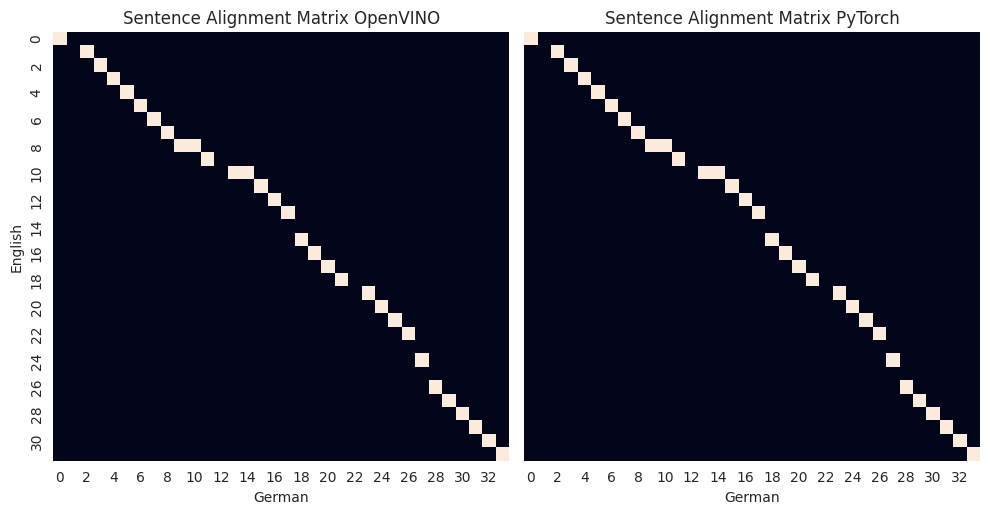

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style("whitegrid")


def transform(x):
    x = x - np.mean(x)
    return x / np.var(x)


def calculate_alignment_matrix(
    first: np.ndarray, second: np.ndarray, threshold: float = 1e-3
) -> np.ndarray:
    similarity = first @ second.T  # 1
    similarity_en_to_de = np.apply_along_axis(transform, -1, similarity)  # 2
    similarity_de_to_en = np.apply_along_axis(transform, -2, similarity)  # 2

    both_one = (similarity_en_to_de > threshold) * (
        similarity_de_to_en > threshold
    )  # 3 and 4
    return both_one


threshold = 0.028

alignment_matrix = calculate_alignment_matrix(embeddings_en, embeddings_de, threshold)
alignment_matrix_pt = calculate_alignment_matrix(
    embeddings_en_pt.detach().numpy(),
    embeddings_de_pt.detach().numpy(),
    threshold,
)

graph, axis = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for matrix, ax, title in zip(
    (alignment_matrix, alignment_matrix_pt), axis, ("OpenVINO", "PyTorch")
):
    plot = sns.heatmap(matrix, cbar=False, square=True, ax=ax)
    plot.set_title(f"Sentence Alignment Matrix {title}")
    plot.set_xlabel("German")
    if title == "OpenVINO":
        plot.set_ylabel("English")

graph.tight_layout()

After visualizing and comparing the alignment matrices, let's transform them into a dictionary to make it more convenient to work with alignment in Python. Dictionary keys will be English sentence numbers and values will be lists of German sentence numbers.

In [19]:
def make_alignment(alignment_matrix: np.ndarray) -> Dict[int, List[int]]:
    aligned = {idx: [] for idx, sent in enumerate(sentences_en)}
    for en_idx, de_idx in zip(*np.nonzero(alignment_matrix)):
        aligned[en_idx].append(de_idx)
    return aligned


aligned = make_alignment(alignment_matrix)
aligned

{0: [0],
 1: [2],
 2: [3],
 3: [4],
 4: [5],
 5: [6],
 6: [7],
 7: [8],
 8: [9, 10],
 9: [11],
 10: [13, 14],
 11: [15],
 12: [16],
 13: [17],
 14: [],
 15: [18],
 16: [19],
 17: [20],
 18: [21],
 19: [23],
 20: [24],
 21: [25],
 22: [26],
 23: [],
 24: [27],
 25: [],
 26: [28],
 27: [29],
 28: [30],
 29: [31],
 30: [32],
 31: [33]}

## Postprocess Sentence Alignment [$\Uparrow$](#Table-of-content:)

There are several gaps in the resulting alignment, such as English sentence #14 not mapping to any German sentence. Here are some possible reasons for this:

1. There are no equivalent sentences in the other book, and in such cases, the model is working correctly.
1. The sentence has an equivalent sentence in another language, but the model failed to identify it. The `threshold` might be too high, or the model is not sensitive enough. To address this, lower the `threshold` value or try a different model.
1. The sentence has an equivalent text part in another language, meaning that either the sentence splitters are too fine or too coarse. Try tuning the text cleaning and splitting steps to fix this issue.
1. Combination of 2 and 3, where both the model's sensitivity and text preparation steps need adjustments.

Another solution to address this issue is by applying heuristics. As you can see, English sentence 13 corresponds to German 17, and 15 to 18. Most likely, English sentence 14 is part of either German sentence 17 or 18. By comparing the similarity using the model, you can choose the most suitable alignment.

## Visualize Sentence Alignment [$\Uparrow$](#Table-of-content:)

To evaluate the final alignment and choose the best way to improve the results of the pipeline, we will create an interactive table with HTML and JS.

In [20]:
from IPython.display import display, HTML
from itertools import zip_longest
from io import StringIO


def create_interactive_table(
    list1: List[str], list2: List[str], mapping: Dict[int, List[int]]
) -> str:
    def inverse_mapping(mapping):
        inverse_map = {idx: [] for idx in range(len(list2))}

        for key, values in mapping.items():
            for value in values:
                inverse_map[value].append(key)

        return inverse_map

    inversed_mapping = inverse_mapping(mapping)

    table_html = StringIO()
    table_html.write(
        '<table id="mappings-table"><tr><th>Sentences EN</th><th>Sentences DE</th></tr>'
    )
    for i, (first, second) in enumerate(zip_longest(list1, list2)):
        table_html.write("<tr>")
        if i < len(list1):
            table_html.write(f'<td id="list1-{i}">{first}</td>')
        else:
            table_html.write("<td></td>")
        if i < len(list2):
            table_html.write(f'<td id="list2-{i}">{second}</td>')
        else:
            table_html.write("<td></td>")
        table_html.write("</tr>")

    table_html.write("</table>")

    hover_script = (
        """
    <script type="module">
      const highlightColor = '#0054AE';
      const textColor = 'white'
      const mappings = {
        'list1': """
        + str(mapping)
        + """,
        'list2': """
        + str(inversed_mapping)
        + """
      };

      const table = document.getElementById('mappings-table');
      let highlightedIds = [];

      table.addEventListener('mouseover', ({ target }) => {
        if (target.tagName !== 'TD' || !target.id) {
          return;
        }

        const [listName, listId] = target.id.split('-');
        const mappedIds = mappings[listName]?.[listId]?.map((id) => `${listName === 'list1' ? 'list2' : 'list1'}-${id}`) || [];
        const idsToHighlight = [target.id, ...mappedIds];

        setBackgroud(idsToHighlight, highlightColor, textColor);
        highlightedIds = idsToHighlight;
      });

      table.addEventListener('mouseout', () => setBackgroud(highlightedIds, ''));

      function setBackgroud(ids, color, text_color="unset") {
        ids.forEach((id) => {
            document.getElementById(id).style.backgroundColor = color;
            document.getElementById(id).style.color = text_color
        });
      }
    </script>
    """
    )
    table_html.write(hover_script)
    return table_html.getvalue()

In [21]:
html_code = create_interactive_table(sentences_en, sentences_de, aligned)
display(HTML(html_code))

Sentences EN,Sentences DE
Happy families are all alike; every unhappy family is unhappy in its own way.,Alle glücklichen Familien sind einander ähnlich; jede unglückliche Familie ist auf hr Weise unglücklich.
Everything was in confusion in the Oblonskys’ house.,--
"The wife had discovered that the husband was carrying on an intrigue with a French girl, who had been a governess in their family, and she had announced to her husband that she could not go on living in the same house with him.",Im Hause der Oblonskiy herrschte allgemeine Verwirrung.
"This position of affairs had now lasted three days, and not only the husband and wife themselves, but all the members of their family and household, were painfully conscious of it.","Die Dame des Hauses hatte in Erfahrung gebracht, daß ihr Gatte mit der im Hause gewesenen französischen Gouvernante ein Verhältnis unterhalten, und ihm erklärt, sie könne fürderhin nicht mehr mit ihm unter einem Dache bleiben."
"Every person in the house felt that there was no sense in their living together, and that the stray people brought together by chance in any inn had more in common with one another than they, the members of the family and household of the Oblonskys.","Diese Situation währte bereits seit drei Tagen und sie wurde nicht allein von den beiden Ehegatten selbst, nein auch von allen Familienmitgliedern und dem Personal aufs Peinlichste empfunden."
"The wife did not leave her own room, the husband had not been at home for three days.","Sie alle fühlten, daß in ihrem Zusammenleben kein höherer Gedanke mehr liege, daß die Leute, welche auf jeder Poststation sich zufällig träfen, noch enger zu einander gehörten, als sie, die Glieder der Familie selbst, und das im Hause geborene und aufgewachsene Gesinde der Oblonskiy."
"The children ran wild all over the house; the English governess quarreled with the housekeeper, and wrote to a friend asking her to look out for a new situation for her; the man-cook had walked off the day before just at dinner time; the kitchen-maid, and the coachman had given warning.","Die Herrin des Hauses verließ ihre Gemächer nicht, der Gebieter war schon seit drei Tagen abwesend."
"Three days after the quarrel, Prince Stepan Arkadyevitch Oblonsky—Stiva, as he was called in the fashionable world—woke up at his usual hour, that is, at eight o’clock in the morning, not in his wife’s bedroom, but on the leather-covered sofa in his study.","Die Kinder liefen wie verwaist im ganzen Hause umher, die Engländerin schalt auf die Wirtschafterin und schrieb an eine Freundin, diese möchte ihr eine neue Stellung verschaffen, der Koch hatte bereits seit gestern um die Mittagszeit das Haus verlassen und die Köchin, sowie der Kutscher hatten ihre Rechnungen eingereicht."
"He turned over his stout, well-cared-for person on the springy sofa, as though he would sink into a long sleep again; he vigorously embraced the pillow on the other side and buried his face in it; but all at once he jumped up, sat up on the sofa, and opened his eyes.","Am dritten Tage nach der Scene erwachte der Fürst Stefan Arkadjewitsch Oblonskiy -- Stiwa hieß er in der Welt -- um die gewöhnliche Stunde, das heißt um acht Uhr morgens, aber nicht im Schlafzimmer seiner Gattin, sondern in seinem Kabinett auf dem Saffiandiwan."
"""Yes, yes, how was it now?"" he thought, going over his dream.","Er wandte seinen vollen verweichlichten Leib auf den Sprungfedern des Diwans, als wünsche er noch weiter zu schlafen, während er von der andern Seite innig ein Kissen umfaßte und an die Wange drückte."


You can see that the pipeline does not fully clean up the German text, resulting in issues like the second sentence consisting of only `--`. On a positive note, the split sentences in the German translation line up correctly with the single English sentence. Overall, the pipeline already works well, but there is still room for improvement.

Save the OpenVINO model to disk for future use:

In [22]:
from openvino.runtime import serialize


ov_model_path = "ov_model/model.xml"
serialize(ov_model, ov_model_path)

To read the model from disk, use the `read_model` method of the `Core` object:

In [23]:
ov_model = core.read_model(ov_model_path)

## Speed up Embeddings Computation [$\Uparrow$](#Table-of-content:)

Let's see how we can speed up the most computationally complex part of the pipeline - getting embeddings. You might wonder why, when using OpenVINO, you need to compile the model after reading it. There are two main reasons for this:
1. Compatibility with different devices. The model can be compiled to run on a [specific device](https://docs.openvino.ai/2023.0/openvino_docs_OV_UG_Working_with_devices.html), like CPU, GPU or GNA. Each device may work with different data types, support different features, and gain performance by changing the neural network for a specific computing model. With OpenVINO, you do not need to store multiple copies of the network with optimized for different hardware. A universal OpenVINO model representation is enough.
1. Optimization for different scenarios. For example, one scenario prioritizes minimizing the _time between starting and finishing model inference_ ([**latency-oriented optimization**](https://docs.openvino.ai/2023.0/openvino_docs_deployment_optimization_guide_latency.html)). In our case, it is more important _how many texts per second the model can process_ ([**throughput-oriented optimization**](https://docs.openvino.ai/2023.0/openvino_docs_deployment_optimization_guide_tput.html)).

To get a throughput-optimized model, pass a [performance hint](https://docs.openvino.ai/2023.0/openvino_docs_OV_UG_Performance_Hints.html#performance-hints-latency-and-throughput) as a configuration during compilation. Then OpenVINO selects the optimal parameters for execution on the available hardware.

In [24]:
from openvino.runtime import Core, AsyncInferQueue, InferRequest
from typing import Any


compiled_throughput_hint = core.compile_model(
    ov_model,
    device_name="CPU",
    config={"PERFORMANCE_HINT": "THROUGHPUT"},
)

To further optimize hardware utilization, let's change the inference mode from synchronous (Sync) to asynchronous (Async). While the synchronous API may be easier to start with, it is [recommended](https://docs.openvino.ai/2022.1/openvino_docs_deployment_optimization_guide_common.html#prefer-openvino-async-api) to use the asynchronous (callbacks-based) API in production code. It is the most general and scalable way to implement flow control for any number of requests.

To work in asynchronous mode, you need to define two things:

1. Instantiate an `AsyncInferQueue`, which can then be populated with inference requests.
1. Define a `callback` function that will be called after the output request has been executed and its results have been processed.
 
In addition to the model input, any data required for post-processing can be passed to the queue. We can create a zero embedding matrix in advance and fill it in as the inference requests are executed.

In [25]:
def get_embeddings_async(sentences: List[str], embedding_model: OVModel) -> np.ndarray:
    def callback(infer_request: InferRequest, user_data: List[Any]) -> None:
        embeddings, idx, pbar = user_data
        embedding = infer_request.get_output_tensor(0).data[0, 0]
        embeddings[idx] = embedding
        pbar.update()

    infer_queue = AsyncInferQueue(embedding_model)
    infer_queue.set_callback(callback)

    embedding_dim = (
        embedding_model.output(0).get_partial_shape().get_dimension(2).get_length()
    )
    embeddings = np.zeros((len(sentences), embedding_dim))

    with tqdm(total=len(sentences), disable=disable_tqdm) as pbar:
        for idx, sent in enumerate(sentences):
            tokenized = tokenizer(sent, return_tensors="np").data

            infer_queue.start_async(tokenized, [embeddings, idx, pbar])

        infer_queue.wait_all()

    return embeddings

Let's compare the models and plot the results.

> **Note**: To get a more accurate benchmark, use the [Benchmark Python Tool](https://docs.openvino.ai/2023.0/openvino_inference_engine_tools_benchmark_tool_README.html)

In [26]:
number_of_chars = 15_000
more_sentences_en = splitter_en.segment(clean_text(anna_karenina_en[:number_of_chars]))
len(more_sentences_en)

  0%|          | 0/3 [00:00<?, ?it/s]

112

In [27]:
import pandas as pd
from time import perf_counter


benchmarks = [
    (pt_model, get_embeddings, "PyTorch"),
    (compiled_model, get_embeddings, "OpenVINO\nSync"),
    (
        compiled_throughput_hint,
        get_embeddings_async,
        "OpenVINO\nThroughput Hint\nAsync",
    ),
]

number_of_sentences = 100
benchmark_data = more_sentences_en[: min(number_of_sentences, len(more_sentences_en))]

benchmark_results = {name: [] for *_, name in benchmarks}

benchmarks_iterator = tqdm(benchmarks, leave=False, disable=disable_tqdm)
for model, func, name in benchmarks_iterator:
    printable_name = name.replace("\n", " ")
    benchmarks_iterator.set_description(f"Run benchmark for {printable_name} model")
    for run in tqdm(
        range(10 + 1), leave=False, desc="Benchmark Runs: ", disable=disable_tqdm
    ):
        with disable_tqdm_context():
            start = perf_counter()
            func(benchmark_data, model)
            end = perf_counter()
        benchmark_results[name].append(len(benchmark_data) / (end - start))

benchmark_dataframe = pd.DataFrame(benchmark_results)[1:]

  0%|          | 0/3 [00:00<?, ?it/s]

Benchmark Runs:   0%|          | 0/11 [00:00<?, ?it/s]

Benchmark Runs:   0%|          | 0/11 [00:00<?, ?it/s]

Benchmark Runs:   0%|          | 0/11 [00:00<?, ?it/s]

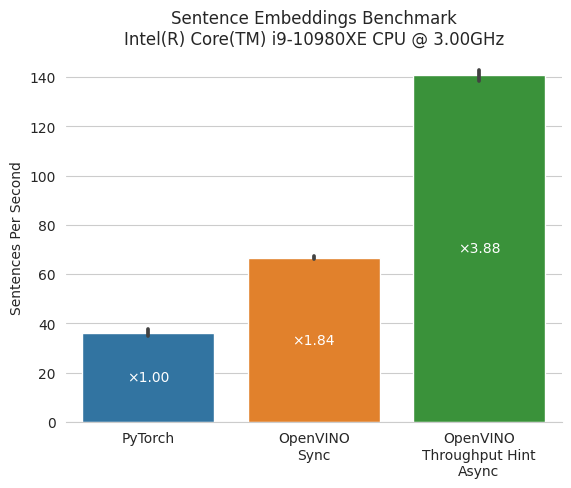

In [28]:
cpu_name = core.get_property("CPU", "FULL_DEVICE_NAME")

plot = sns.barplot(benchmark_dataframe, errorbar="sd")
plot.set(
    ylabel="Sentences Per Second", title=f"Sentence Embeddings Benchmark\n{cpu_name}"
)
perf_ratio = benchmark_dataframe.mean() / benchmark_dataframe.mean()[0]
plot.bar_label(
    plot.containers[0],
    labels=[f"×{ratio:.2f}" for ratio in perf_ratio],
    color="white",
    label_type="center",
)
plot.spines["right"].set_visible(False)
plot.spines["top"].set_visible(False)
plot.spines["left"].set_visible(False)

On an Intel Core i9-10980XE CPU, the OpenVINO model processed 45% more sentences per second compared with the original PyTorch model. Using Async mode with throughput hint, we get ×3.21 (or 221%) performance boost.

Here are useful links with information about the techniques used in this notebook:
- [OpenVINO performance hints](https://docs.openvino.ai/2023.0/openvino_docs_OV_UG_Performance_Hints.html)
- [OpenVINO Async API](https://docs.openvino.ai/2023.0/openvino_docs_deployment_optimization_guide_common.html#prefer-openvino-async-api)
- [Throughput Optimizations](https://docs.openvino.ai/2023.0/openvino_docs_deployment_optimization_guide_tput.html)